In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *

from joblib import Parallel, delayed
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

np.set_printoptions(linewidth=120)

In [2]:
import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [3]:
pred = np.load(f'outputs/Sei_pred_crop_4096_zero.npy')
print(pred.shape)
print(pred.mean())

target = np.load('../data/Sei/sei_chr8_dataset_label.npy')
print(target.shape)
print(target.mean())

(10000, 21907)
0.005537783
(10000, 21907)
0.004913534486693751


In [4]:
def compute_classification_metrics(target, pred):
    # 如果标签包括0和1
    if np.any(target==0) and np.any(target==1):
        report = classification_report(target, pred > 0.5, labels=[0, 1], output_dict=True, zero_division=0)
        return np.array([
            report['1']['support'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score'],
            roc_auc_score(target, pred, labels=[0,1]),
            average_precision_score(target, pred)
        ])
    else:  # 全是 0，返回 NaNs
        return np.full(6, np.nan)


def compute_metrics_for_each_column_parallel(target, pred, n_jobs=-1):  # -1 使用所有 CPU 核
    num_columns = target.shape[1]
    with tqdm_joblib(tqdm(total=num_columns)) as progress_bar:
        results = Parallel(n_jobs=n_jobs)(
            delayed(compute_classification_metrics)(target[:, i], pred[:, i]) for i in range(num_columns)
        )
    return np.vstack(results)

In [5]:
# sei
target = np.load('../data/Sei/sei_chr8_dataset_label.npy')
print(target.shape)

length_list = np.array([4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
positions = np.log2(length_list)

(10000, 21907)


In [ ]:
# pad zero
pred_list = []
score_list = []
for cropped_length in length_list:
    # pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_N.npy')
    # pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_zero.npy')
    # pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_random.npy')
    # pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_genome.npy')
    pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_repeat.npy')
    pred_list.append(pred)
    score = compute_metrics_for_each_column_parallel(target, pred)
    score_list.append(score)
pred_list = np.stack(pred_list)
score_list = np.stack(score_list)

# np.save('Sei_score_N', score_list)
# np.save('Sei_score_zero.npy', score_list)
# np.save('Sei_score_random.npy', score_list)
# np.save('Sei_score_genome.npy', score_list)
np.save('Sei_score_repeat.npy', score_list)

In [ ]:
# score_list = np.load('Sei_score_random_5_times.npy')
# score_list = score_list.reshape(len(length_list), 5, -1, 6)
# np.save('Sei_score_random_5_times.npy', score_list)

In [ ]:
score_list = []
for cropped_length in length_list:
    for seed in range(5):
        pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_random_{seed}.npy')
        score = compute_metrics_for_each_column_parallel(target, pred)
        score_list.append(score)
score_list = np.stack(score_list)
score_list = score_list.reshape(len(length_list), 5, -1, 6)
print(score_list.shape)
np.save('Sei_score_random_5_times.npy', score_list)


score_list = []
for cropped_length in length_list:
    pred_list = []
    for seed in range(5):
        pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_random_{seed}.npy')
        pred_list.append(pred)
    pred_list = np.stack(pred_list)
    pred = np.mean(pred_list, axis=0)
    score = compute_metrics_for_each_column_parallel(target, pred)
    score_list.append(score)

score_list = np.stack(score_list)
print(score_list.shape)
np.save('Sei_score_random_mean.npy', score_list)







score_list = []
for cropped_length in length_list:
    for seed in range(5):
        pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_genome_{seed}.npy')
        score = compute_metrics_for_each_column_parallel(target, pred)
        score_list.append(score)
score_list = np.stack(score_list)
score_list = score_list.reshape(len(length_list), 5, -1, 6)
print(score_list.shape)
np.save('Sei_score_genome_5_times.npy', score_list)


score_list = []
for cropped_length in length_list:
    pred_list = []
    for seed in range(5):
        pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_genome_{seed}.npy')
        pred_list.append(pred)
    pred_list = np.stack(pred_list)
    pred = np.mean(pred_list, axis=0)
    score = compute_metrics_for_each_column_parallel(target, pred)
    score_list.append(score)

score_list = np.stack(score_list)
print(score_list.shape)
np.save('Sei_score_genome_mean.npy', score_list)

In [ ]:
# plt.figure(figsize=(12, 9), dpi=100)
# plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)


# score_list = np.load('Sei_score_N.npy')
# data = np.nanmean(score_list[:, :, 4], axis=1)
# plt.plot(positions, data, marker="o", markersize=4, label='padding N (N=0.25)', color=tab20_colors[0],)

# score_list = np.load('Sei_score_zero.npy')
# data = np.nanmean(score_list[:, :, 4], axis=1)
# plt.plot(positions, data, marker="o", markersize=4, label='padding N (N=0)', color=tab20_colors[1],)

# score_list = np.load('Sei_score_repeat.npy')
# data = np.nanmean(score_list[:, :, 4], axis=1)
# plt.plot(positions, data, marker="o", markersize=4, label='padding repead', color=tab20_colors[8],)

# score_list = np.load('Sei_score_random.npy')
# data = np.nanmean(score_list[:, :, 4], axis=1)
# plt.plot(positions, data, marker="o", markersize=4, label='padding random', color=tab20_colors[2],)

# score_list = np.load('Sei_score_genome.npy')
# data = np.nanmean(score_list[:, :, 4], axis=1)
# plt.plot(positions, data, marker="o", markersize=4, label='padding genome', color=tab20_colors[4],)



# handles, labels = plt.gca().get_legend_handles_labels()
# desired_order = [
#     'padding N (N=0.25)',
#     'padding N (N=0)',
#     'padding repead',
#     'padding random',
#     'padding genome',
# ]
# # 1. 先把 labels 与 handles 对应起来
# label_to_handle = dict(zip(labels, handles))

# # 2. 根据想要的顺序（desired_order）挑选 handle 并重组
# reordered_handles = [label_to_handle[label] for label in desired_order]
# reordered_labels = desired_order  # 与 reordered_handles 里的顺序一致

# # 3. 在 legend 中按照新的顺序排列
# plt.legend(reordered_handles, reordered_labels, fontsize=16, loc='lower right')


# x_labels = [4, 16, 64, 256, 1024, 4096]
# x_ticks = np.log2(x_labels)

# plt.xlim(np.min(positions)-0.5, np.max(positions)+0.5)
# plt.ylim(0.5, 1.0)
# plt.xticks(x_ticks, x_labels)
# plt.yticks(np.arange(0.4, 1.01, 0.1))
# plt.xlabel('Valid sequence length')
# plt.ylabel('Mean AUROC')

# plt.savefig('figures/Sei_padding_AUROC.png', dpi=400)
# plt.show()

(11, 5, 21907, 6)
(11, 5, 21907, 6)


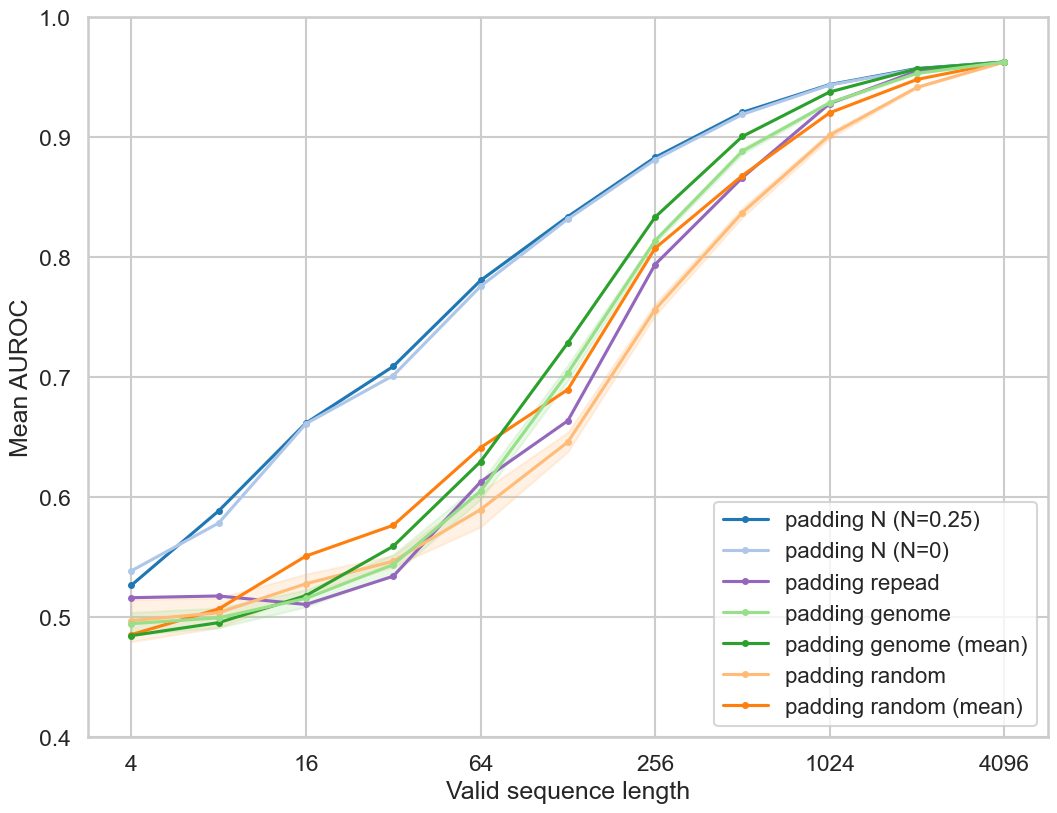

In [8]:
plt.figure(figsize=(12, 9), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)

score_list = np.load('Sei_score_N.npy')
data = np.nanmean(score_list[:, :, 4], axis=1)
plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding N (N=0.25)',
    color=tab20_colors[0],
)

score_list = np.load('Sei_score_zero.npy')
data = np.nanmean(score_list[:, :, 4], axis=1)
plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding N (N=0)',
    color=tab20_colors[1],
)

score_list = np.load('Sei_score_repeat.npy')
data = np.nanmean(score_list[:, :, 4], axis=1)
plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding repead',
    color=tab20_colors[8],
)

# score_list = np.load('Sei_score_no.npy')
# data = np.nanmean(score_list[:, :, 4], axis=1)
# plt.plot(
#     positions,
#     data,
#     marker="o",
#     markersize=4,
#     label='padding nothing',
#     color=tab20_colors[10],
# )

score_list = np.load('Sei_score_random_mean.npy')
data = np.nanmean(score_list[:, :, 4], axis=1)
plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding random (mean)',
    color=tab20_colors[2],
)

score_list = np.load('Sei_score_random_5_times.npy')
print(score_list.shape)
replicate_mean = np.nanmean(score_list[:, :, :, 4], axis=2)
# 对 5 次重复在 axis=0 做平均和标准差
data = np.mean(replicate_mean, axis=1)     # shape (11,)
data_std = np.std(replicate_mean, axis=1)  # shape (11,)
# plt.errorbar(positions, data, yerr=data_std, marker="o", markersize=4, label='padding genome', color=tab20_colors[5],)

plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding random',
    color=tab20_colors[3],
)
# 在「mean ± std」区域之间填充半透明色
plt.fill_between(
    positions,
    data - data_std,
    data + data_std,
    color=tab20_colors[3],
    alpha=0.2,
)

score_list = np.load('Sei_score_genome_mean.npy')
data = np.nanmean(score_list[:, :, 4], axis=1)
plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding genome (mean)',
    color=tab20_colors[4],
)

score_list = np.load('Sei_score_genome_5_times.npy')
print(score_list.shape)
replicate_mean = np.nanmean(score_list[:, :, :, 4], axis=2)
data = np.mean(replicate_mean, axis=1)     # shape (11,)
data_std = np.std(replicate_mean, axis=1)  # shape (11,)

plt.plot(
    positions,
    data,
    marker="o",
    markersize=4,
    label='padding genome',
    color=tab20_colors[5],
)
plt.fill_between(
    positions,
    data - data_std,
    data + data_std,
    color=tab20_colors[5],
    alpha=0.2,
)

handles, labels = plt.gca().get_legend_handles_labels()
desired_order = [
    # 'padding nothing',
    'padding N (N=0.25)',
    'padding N (N=0)',
    'padding repead',
    'padding genome',
    'padding genome (mean)',
    'padding random',
    'padding random (mean)',
]
# 1. labels 与 handles 对应
label_to_handle = dict(zip(labels, handles))
# 2. 按 desired_order 重排
reordered_handles = [label_to_handle[label] for label in desired_order]
reordered_labels = desired_order

plt.legend(reordered_handles, reordered_labels, fontsize=16, loc='lower right')

# x_ticks = [8, 10, 12, 14, 16, 16 + np.log2(3), 18]
# x_labels = [256, 1024, 4096, 16384, 65536, 196608, '']
# plt.xlim(np.min(positions) - 1, np.max(positions) + 1)
# plt.ylim(0.1, 0.7)
# plt.xticks(x_ticks, x_labels)
# plt.yticks(np.arange(0.1, 0.71, 0.1))
# plt.xlabel('Valid sequence length')
# plt.ylabel('Mean AUROC')




x_labels = [4, 16, 64, 256, 1024, 4096]
x_ticks = np.log2(x_labels)
plt.xlim(np.min(positions)-0.5, np.max(positions)+0.5)
plt.ylim(0.5, 1.0)
plt.xticks(x_ticks, x_labels)
plt.yticks(np.arange(0.4, 1.01, 0.1))
plt.xlabel('Valid sequence length')
plt.ylabel('Mean AUROC')

plt.savefig('figures/Sei_padding_AUROC.png', dpi=400)
plt.show()


In [ ]:
# plt.figure(figsize=(12, 9), dpi=100)
# plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)


# score_list = np.load('Sei_score_N.npy')
# data = np.nanmean(score_list[:, :, 5], axis=1)
# plt.plot(positions, data, marker="o", markersize=4, label='padding N (N=0.25)', color=tab20_colors[0],)

# score_list = np.load('Sei_score_zero.npy')
# data = np.nanmean(score_list[:, :, 5], axis=1)
# plt.plot(positions, data, marker="o", markersize=4, label='padding N (N=0)', color=tab20_colors[1],)

# score_list = np.load('Sei_score_repeat.npy')
# data = np.nanmean(score_list[:, :, 5], axis=1)
# plt.plot(positions, data, marker="o", markersize=4, label='padding repead', color=tab20_colors[8],)

# score_list = np.load('Sei_score_random.npy')
# data = np.nanmean(score_list[:, :, 5], axis=1)
# plt.plot(positions, data, marker="o", markersize=4, label='padding random', color=tab20_colors[2],)

# score_list = np.load('Sei_score_genome.npy')
# data = np.nanmean(score_list[:, :, 5], axis=1)
# plt.plot(positions, data, marker="o", markersize=4, label='padding genome', color=tab20_colors[4],)




# handles, labels = plt.gca().get_legend_handles_labels()
# desired_order = [
#     'padding N (N=0.25)',
#     'padding N (N=0)',
#     'padding repead',
#     'padding random',
#     'padding genome',
# ]
# # 1. 先把 labels 与 handles 对应起来
# label_to_handle = dict(zip(labels, handles))

# # 2. 根据想要的顺序（desired_order）挑选 handle 并重组
# reordered_handles = [label_to_handle[label] for label in desired_order]
# reordered_labels = desired_order  # 与 reordered_handles 里的顺序一致

# # 3. 在 legend 中按照新的顺序排列
# plt.legend(reordered_handles, reordered_labels, fontsize=16, loc='lower right')



# x_labels = [4, 16, 64, 256, 1024, 4096]
# x_ticks = np.log2(x_labels)

# plt.xlim(np.min(positions)-0.5, np.max(positions)+0.5)
# plt.ylim(0.0, 0.5)
# plt.xticks(x_ticks, x_labels)
# plt.yticks(np.arange(0.0, 0.51, 0.1))
# plt.xlabel('Valid sequence length')
# plt.ylabel('Mean AUPRC')

# plt.savefig('figures/Sei_padding_AUPRC.png', dpi=400)
# plt.show()

In [ ]:
length_list = np.array([256, 512, 1024, 2048, 4096])
# score_list.shape: (num_lengths, num_tasks, metrics)
AUROC_data = score_list[:, :, 4]
AUROC_data = AUROC_data[:, ~np.isnan(AUROC_data).any(axis=0)]


positions = np.log2(length_list)

plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)

plt.violinplot(
    [AUROC_data[i, :] for i in range(len(length_list))],
    positions=positions,
    showextrema=False,
)

plt.xlim(7.5, 12.5)
plt.ylim(0.5, 1.0)
plt.xticks(positions, length_list)
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlabel('Valid sequence length')
plt.ylabel('AUROC')

plt.savefig('figures/Sei_padding_AUROC_boxplot.png', dpi=400)
plt.show()